## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI2D-coronal' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
vertical_wavelet_coronal_syntheticMRI2D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI2D/coronal/wavelet/vertical'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 0,
 3: 19544,
 4: 177766,
 5: 820632,
 6: 3670424,
 7: 15384514,
 8: 62976002,
 9: 254776200}

Running 12760 CDFs


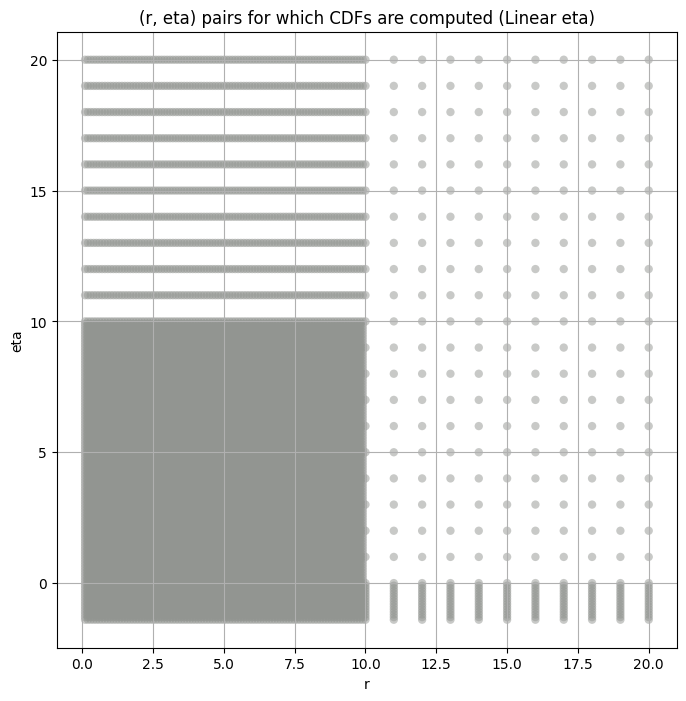

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:18<00:00, 5541.39it/s]


Layer 3


100%|██████████| 100000/100000 [00:46<00:00, 2170.66it/s]


Layer 4


100%|██████████| 100000/100000 [00:40<00:00, 2478.73it/s]


Layer 5


100%|██████████| 100000/100000 [00:40<00:00, 2483.60it/s]


Layer 6


100%|██████████| 100000/100000 [00:40<00:00, 2475.02it/s]


Layer 7


100%|██████████| 100000/100000 [00:40<00:00, 2473.12it/s]


Layer 8


100%|██████████| 100000/100000 [00:43<00:00, 2304.37it/s]


Layer 9


100%|██████████| 100000/100000 [00:42<00:00, 2365.46it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,946814.5600,917571.90000,976698.900000,-0.538544,-0.614867,-0.456596,19544.0
4,391889.4400,377544.62000,406418.840000,0.024666,-0.124355,0.191041,177766.0
5,115589.1400,110075.95000,121213.900000,1.517275,1.208930,1.873680,820632.0
6,35460.4960,32829.09400,38199.375000,6.683017,5.882577,7.561228,3670424.0
7,6775.7340,6192.90530,7381.213000,9.732124,8.434924,11.334869,15384514.0
8,735.1625,664.87320,812.648600,13.064596,9.912193,20.730494,62976002.0
9,65.5812,57.39219,75.238235,25.357120,15.238648,48.869812,254776200.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,946814.5600,946814.562500,928173.187500,913768.625000,900756.000000,888535.375000,866120.750000,846006.312500,827568.375000,810429.250000,794359.250000,750930.375000
4,391889.4400,391889.437500,388954.687500,386605.656250,384513.406250,382566.000000,378974.656250,375686.218750,372644.812500,369794.718750,367107.375000,359815.281250
5,115589.1400,115589.140625,114269.531250,113251.867188,112340.398438,111501.195312,109969.679688,108590.296875,107322.406250,106135.078125,105015.945312,101965.617188
6,35460.4960,35460.496094,34778.378906,34214.808594,33699.214844,33215.757812,32322.927734,31503.261719,30741.357422,30027.884766,29355.306641,27546.095703
7,6775.7340,6775.733887,6603.063965,6463.230469,6336.883789,6220.147949,6008.110840,5817.196289,5642.824219,5482.103027,5332.779297,4938.265625
8,735.1625,735.162476,707.424133,689.664246,674.050171,659.839539,634.410217,611.939880,591.705200,573.283264,556.374146,512.686951
9,65.5812,65.581200,61.200771,58.812321,56.822147,55.092941,52.176086,49.769226,47.719810,45.932415,44.345726,40.430233


####
Layer  2
####
Layer  3


100%|██████████| 12760/12760 [00:09<00:00, 1411.69it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.058963557966840496 946814.56


100%|██████████| 12760/12760 [00:08<00:00, 1478.00it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.06042832347011534 928173.2


100%|██████████| 12760/12760 [00:08<00:00, 1487.91it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.06158902525031945 913768.6


100%|██████████| 12760/12760 [00:08<00:00, 1489.23it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.0626600521389526 900756.0


100%|██████████| 12760/12760 [00:08<00:00, 1476.78it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.06368600430616789 888535.4


100%|██████████| 12760/12760 [00:08<00:00, 1488.79it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.06562057168246405 866120.75


100%|██████████| 12760/12760 [00:08<00:00, 1472.57it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.06725809891819434 846006.3


100%|██████████| 12760/12760 [00:08<00:00, 1458.92it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.06895794716798137 827568.4


100%|██████████| 12760/12760 [00:08<00:00, 1490.10it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.07058761504370803 810429.25


100%|██████████| 12760/12760 [00:08<00:00, 1465.14it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.07216541428192425 794359.25


100%|██████████| 12760/12760 [00:08<00:00, 1469.17it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.07715125898563324 750930.4
Number of samples: 19544, Without approximation : 19544.0


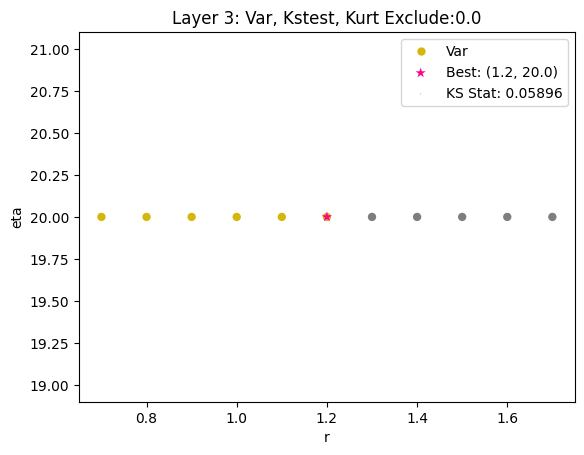

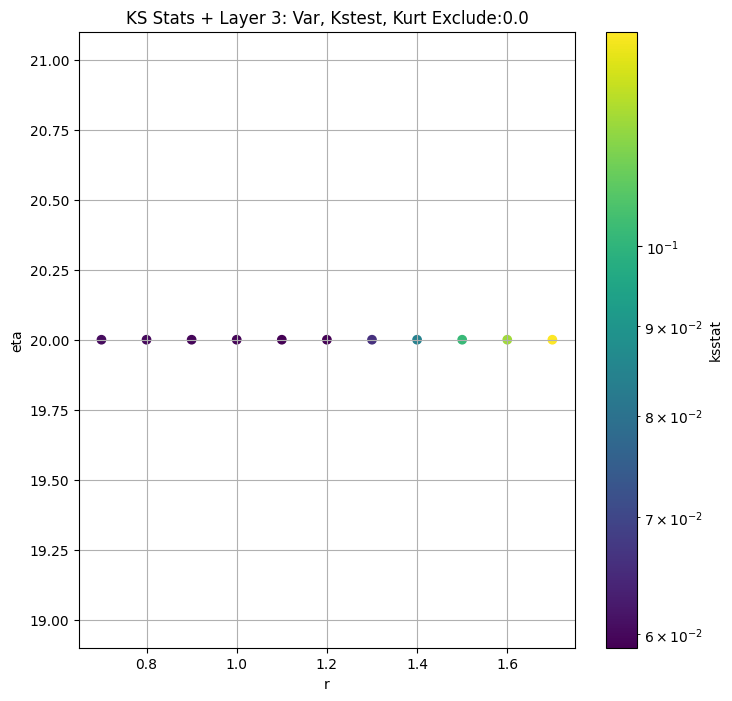

####
Layer  4


100%|██████████| 12760/12760 [00:44<00:00, 289.58it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.022741035533411502 391889.44


100%|██████████| 12760/12760 [00:42<00:00, 299.43it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.02333848499393043 388954.7


100%|██████████| 12760/12760 [00:42<00:00, 302.21it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.023821265036110262 386605.66


100%|██████████| 12760/12760 [00:42<00:00, 302.79it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.024254742734798718 384513.4


100%|██████████| 12760/12760 [00:58<00:00, 216.84it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.024661188890957475 382566.0


100%|██████████| 12760/12760 [08:50<00:00, 24.04it/s] 


Finding Minimum after computing 12760 CDFs
4 150 0.025419508289739268 378974.66


100%|██████████| 12760/12760 [03:13<00:00, 65.83it/s] 


Finding Minimum after computing 12760 CDFs
4 200 0.02612309233237098 375686.22


100%|██████████| 12760/12760 [01:59<00:00, 106.35it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.026781524778917487 372644.8


100%|██████████| 12760/12760 [01:47<00:00, 118.50it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.027426542757932326 369794.72


100%|██████████| 12760/12760 [08:47<00:00, 24.17it/s]  


Finding Minimum after computing 12760 CDFs
4 350 0.028066552188610983 367107.38


100%|██████████| 12760/12760 [01:10<00:00, 180.78it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.029836091408906806 359815.28
Number of samples: 100000, Without approximation : 177766.0


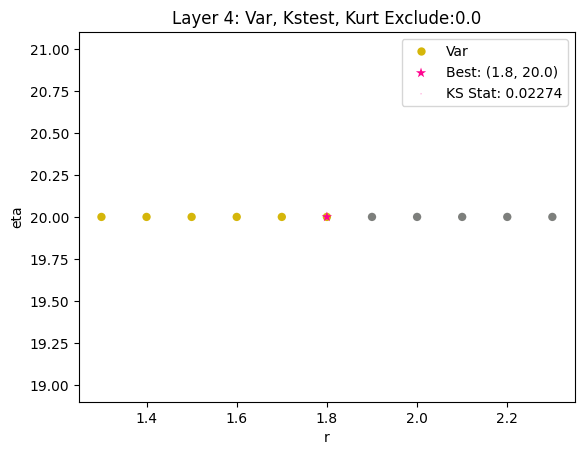

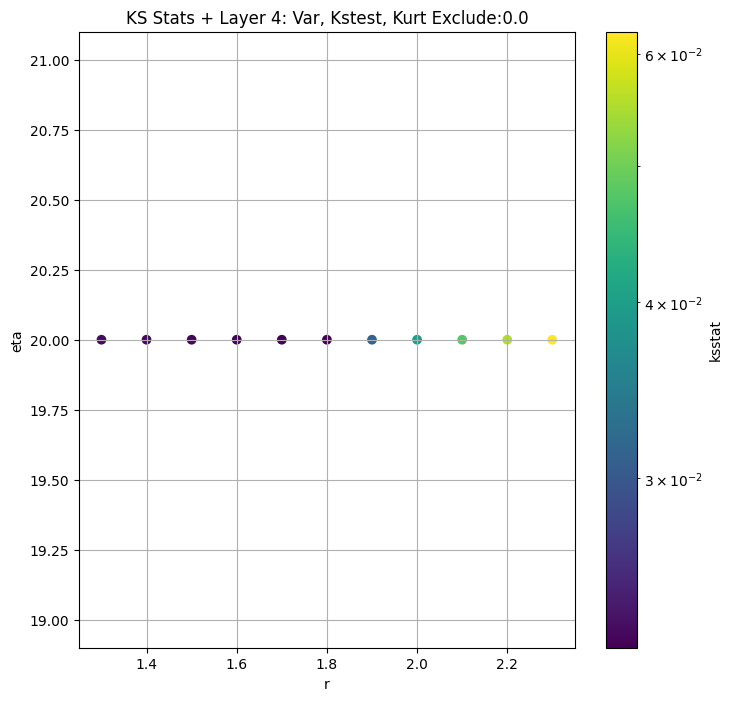

####
Layer  5


100%|██████████| 12760/12760 [01:11<00:00, 179.23it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.0036475164688985068 115589.14


100%|██████████| 12760/12760 [01:08<00:00, 187.53it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.004291267636863216 114269.53


100%|██████████| 12760/12760 [01:08<00:00, 187.36it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.004788610486879584 113251.87


100%|██████████| 12760/12760 [01:08<00:00, 186.71it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.005234693431148803 112340.4


100%|██████████| 12760/12760 [01:08<00:00, 187.35it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.005687080461128806 111501.195


100%|██████████| 12760/12760 [01:08<00:00, 187.37it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.00650378442950976 109969.68


100%|██████████| 12760/12760 [01:08<00:00, 186.95it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.007199928459729409 108590.3


100%|██████████| 12760/12760 [01:07<00:00, 187.69it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.007910646713405356 107322.41


100%|██████████| 12760/12760 [01:08<00:00, 186.09it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.00859967374870365 106135.08


100%|██████████| 12760/12760 [01:08<00:00, 187.29it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.009222044925134613 105015.945


100%|██████████| 12760/12760 [01:09<00:00, 183.53it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.01107561294258192 101965.62
Number of samples: 100000, Without approximation : 820632.0


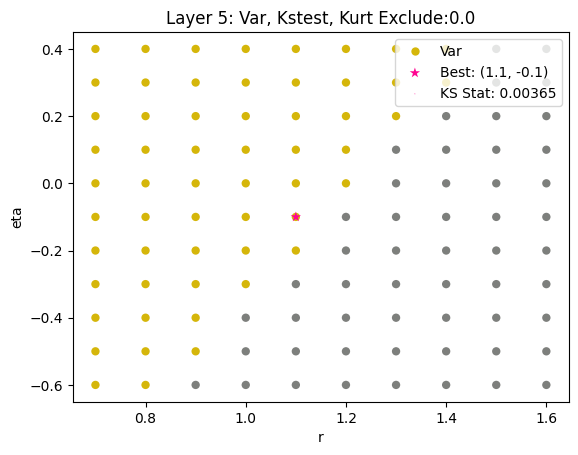

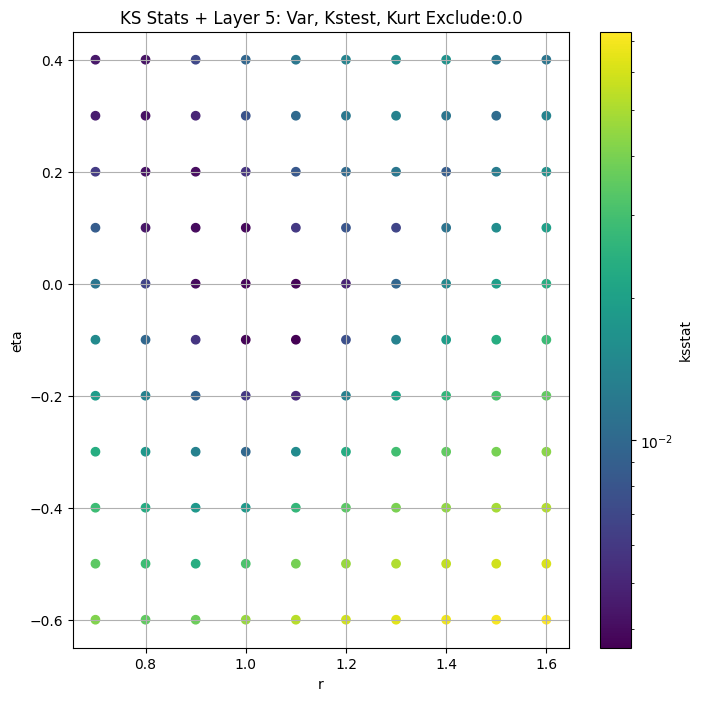

####
Layer  6


100%|██████████| 12760/12760 [01:08<00:00, 186.58it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.006968461355118166 35460.496


100%|██████████| 12760/12760 [01:08<00:00, 187.57it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.006124613511508836 34778.38


100%|██████████| 12760/12760 [01:08<00:00, 187.21it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.00646222041140973 34214.81


100%|██████████| 12760/12760 [01:08<00:00, 186.50it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.007259198133094891 33699.215


100%|██████████| 12760/12760 [01:07<00:00, 187.92it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.006578880268805029 33215.758


100%|██████████| 12760/12760 [01:07<00:00, 187.69it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.006847798776323244 32322.928


100%|██████████| 12760/12760 [01:07<00:00, 187.69it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.005882656620975313 31503.262


100%|██████████| 12760/12760 [01:08<00:00, 185.87it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.005309385973326308 30741.357


100%|██████████| 12760/12760 [01:07<00:00, 187.71it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.005640594834295727 30027.885


100%|██████████| 12760/12760 [01:08<00:00, 187.08it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.006314501117871497 29355.307


100%|██████████| 12760/12760 [01:07<00:00, 187.71it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.007460386072920988 27546.096
Number of samples: 100000, Without approximation : 3670424.0


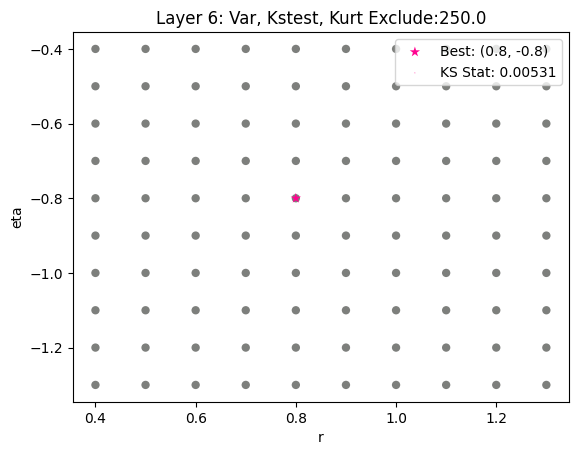

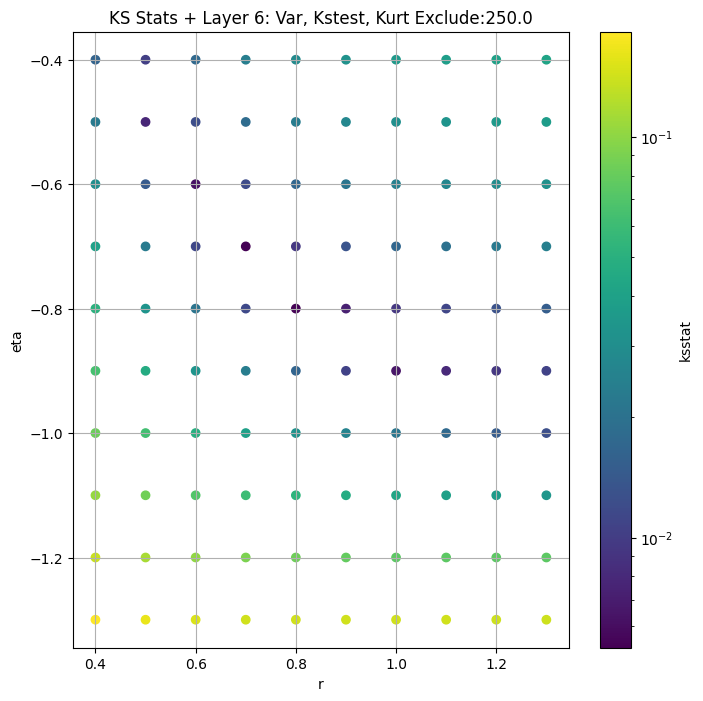

####
Layer  7


100%|██████████| 12760/12760 [01:08<00:00, 187.49it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.0071695353598889705 6775.734


100%|██████████| 12760/12760 [01:08<00:00, 187.32it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.005721091095136591 6603.064


100%|██████████| 12760/12760 [01:08<00:00, 186.70it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.0054125419111960005 6463.2305


100%|██████████| 12760/12760 [01:07<00:00, 187.83it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.006859687498597 6336.884


100%|██████████| 12760/12760 [01:08<00:00, 187.41it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.006007262257958154 6220.148


100%|██████████| 12760/12760 [01:08<00:00, 187.25it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.004147624273246331 6008.111


100%|██████████| 12760/12760 [01:08<00:00, 187.60it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.005983652265679762 5817.1963


100%|██████████| 12760/12760 [01:07<00:00, 187.78it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.005942141047678706 5642.824


100%|██████████| 12760/12760 [01:08<00:00, 187.65it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.005501624778659231 5482.103


100%|██████████| 12760/12760 [01:08<00:00, 187.49it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.005860444569246069 5332.7793


100%|██████████| 12760/12760 [01:08<00:00, 187.58it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.007257384029166036 4938.2656
Number of samples: 100000, Without approximation : 15384514.0


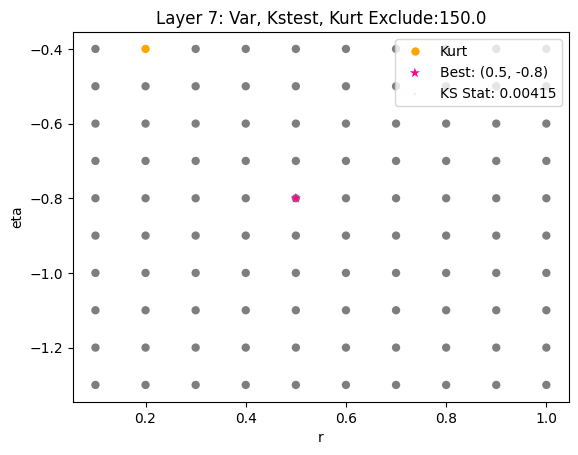

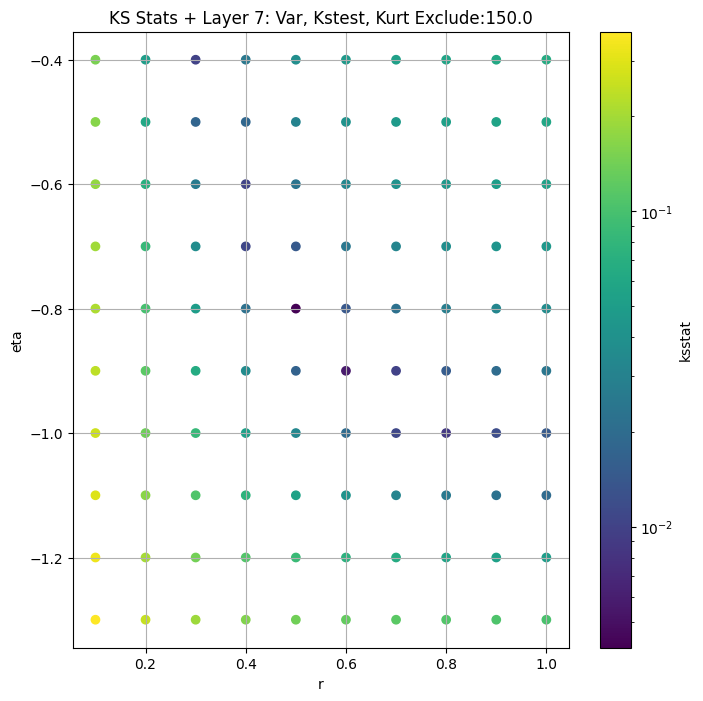

####
Layer  8


100%|██████████| 12760/12760 [01:08<00:00, 187.39it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.004570940309985949 735.1625


100%|██████████| 12760/12760 [01:07<00:00, 187.77it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.004951593356546158 707.42413


100%|██████████| 12760/12760 [01:08<00:00, 187.48it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.004530963632383617 689.66425


100%|██████████| 12760/12760 [01:07<00:00, 187.92it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.005926507726212643 674.0502


100%|██████████| 12760/12760 [01:07<00:00, 187.96it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.004692556399940456 659.83954


100%|██████████| 12760/12760 [01:07<00:00, 187.74it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.005299704731477756 634.4102


100%|██████████| 12760/12760 [01:08<00:00, 187.26it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.0067097795309080666 611.9399


100%|██████████| 12760/12760 [01:08<00:00, 187.60it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.005230516978431021 591.7052


100%|██████████| 12760/12760 [01:08<00:00, 187.62it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.005164784691769255 573.28326


100%|██████████| 12760/12760 [01:08<00:00, 187.32it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.005597972643921924 556.37415


100%|██████████| 12760/12760 [01:08<00:00, 187.49it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007235126288490434 512.68695
Number of samples: 100000, Without approximation : 62976002.0


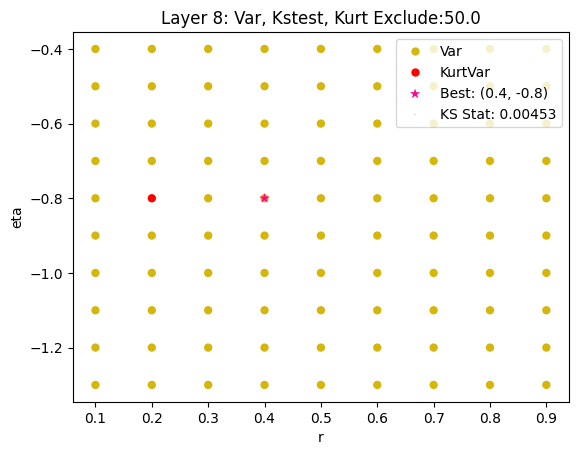

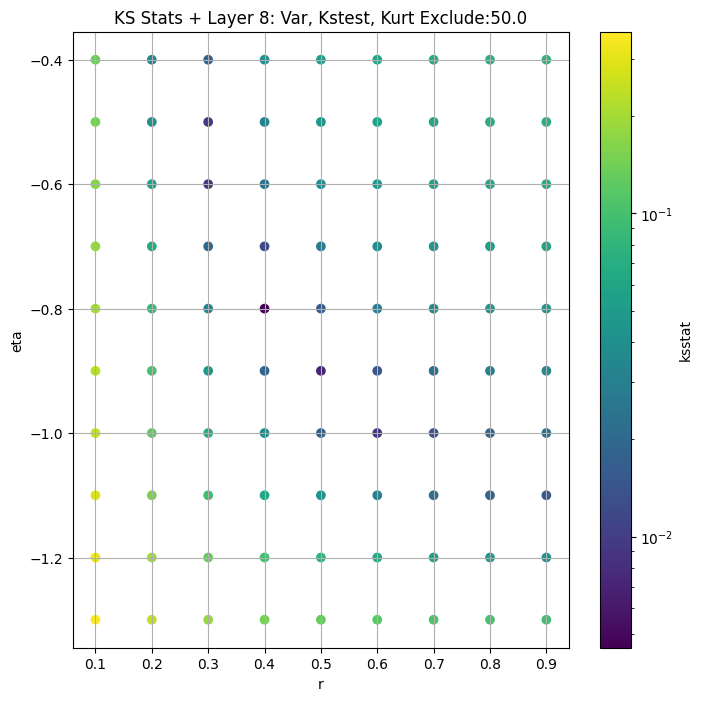

####
Layer  9


100%|██████████| 12760/12760 [01:08<00:00, 187.40it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.005672464296774593 65.5812


100%|██████████| 12760/12760 [01:08<00:00, 187.21it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.005316175458250638 61.20077


100%|██████████| 12760/12760 [01:08<00:00, 187.10it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.003018647637752392 58.81232


100%|██████████| 12760/12760 [01:08<00:00, 186.66it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.0030654470366083264 56.822147


100%|██████████| 12760/12760 [01:10<00:00, 180.12it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.003972728838027961 55.09294


100%|██████████| 12760/12760 [01:08<00:00, 185.55it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.006316255107685964 52.176086


100%|██████████| 12760/12760 [01:13<00:00, 174.46it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.005491596884137417 49.769226


100%|██████████| 12760/12760 [01:08<00:00, 185.13it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.0047645195423035025 47.71981


100%|██████████| 12760/12760 [01:08<00:00, 186.45it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.005235341299231288 45.932415


100%|██████████| 12760/12760 [01:08<00:00, 186.03it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.005989675593919646 44.345726


100%|██████████| 12760/12760 [01:08<00:00, 185.39it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.007688466084729062 40.430233
Number of samples: 100000, Without approximation : 254776200.0


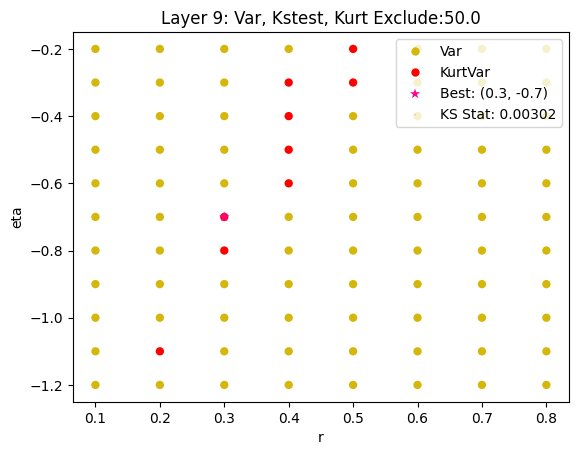

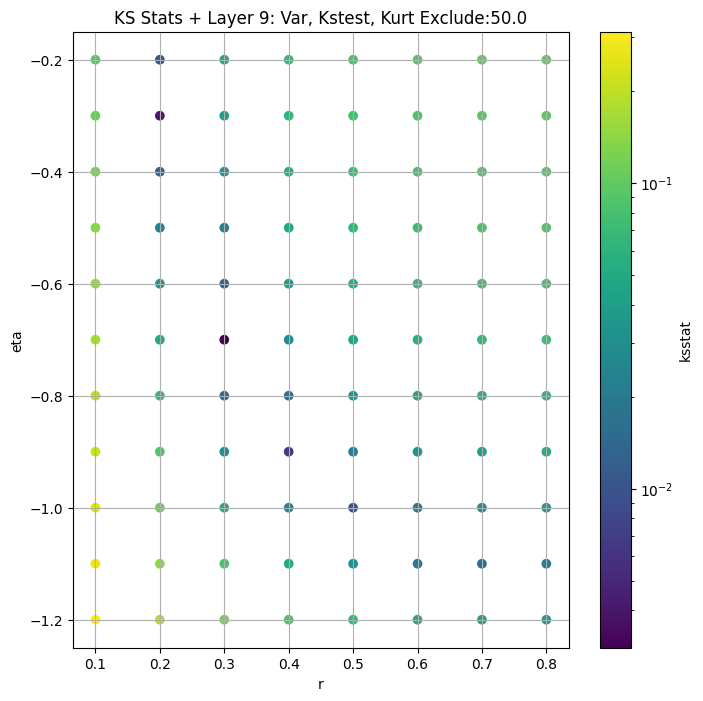

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,946814.5600,917571.90000,976698.900000,-0.538544,-0.614867,-0.456596,19544.0,0.058964,1.2,20.0,85813.709057,0.0,946814.56000,0.009706
4,391889.4400,377544.62000,406418.840000,0.024666,-0.124355,0.191041,177766.0,0.022741,1.8,20.0,99820.241572,0.0,391889.44000,0.003220
5,115589.1400,110075.95000,121213.900000,1.517275,1.208930,1.873680,820632.0,0.003648,1.1,-0.1,95560.656558,0.0,115589.14000,0.001499
6,35460.4960,32829.09400,38199.375000,6.683017,5.882577,7.561228,3670424.0,0.005309,0.8,-0.8,31617.404712,250.0,30741.35700,0.000709
7,6775.7340,6192.90530,7381.213000,9.732124,8.434924,11.334869,15384514.0,0.004148,0.5,-0.8,1788.128226,150.0,6008.11100,0.000346
8,735.1625,664.87320,812.648600,13.064596,9.912193,20.730494,62976002.0,0.004531,0.4,-0.8,76.504291,50.0,689.66425,0.000171
9,65.5812,57.39219,75.238235,25.357120,15.238648,48.869812,254776200.0,0.003019,0.3,-0.7,0.737396,50.0,58.81232,0.000085


In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2
Layer 3


100%|██████████| 99/99 [00:00<00:00, 861.89it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.06355847994489117, var: 888535.375


100%|██████████| 99/99 [00:00<00:00, 896.06it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.06253313602874977, var: 900756.0


100%|██████████| 99/99 [00:00<00:00, 895.03it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.0614776613492537, var: 913768.625


100%|██████████| 99/99 [00:00<00:00, 898.72it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.06033264144761219, var: 928173.1875


100%|██████████| 99/99 [00:00<00:00, 892.93it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.05888375223093356, var: 946814.5625
Number of samples: 19544, Without approximation : 19544.0


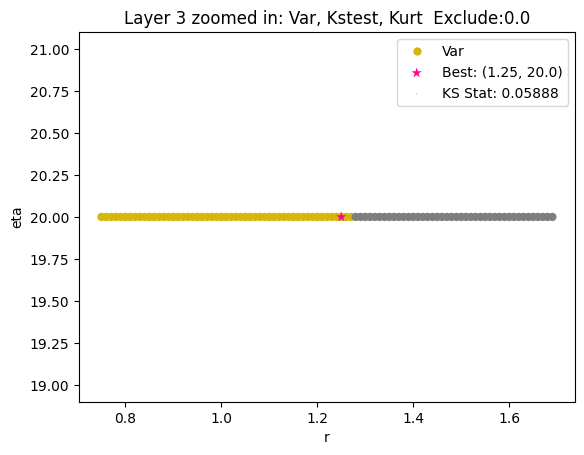

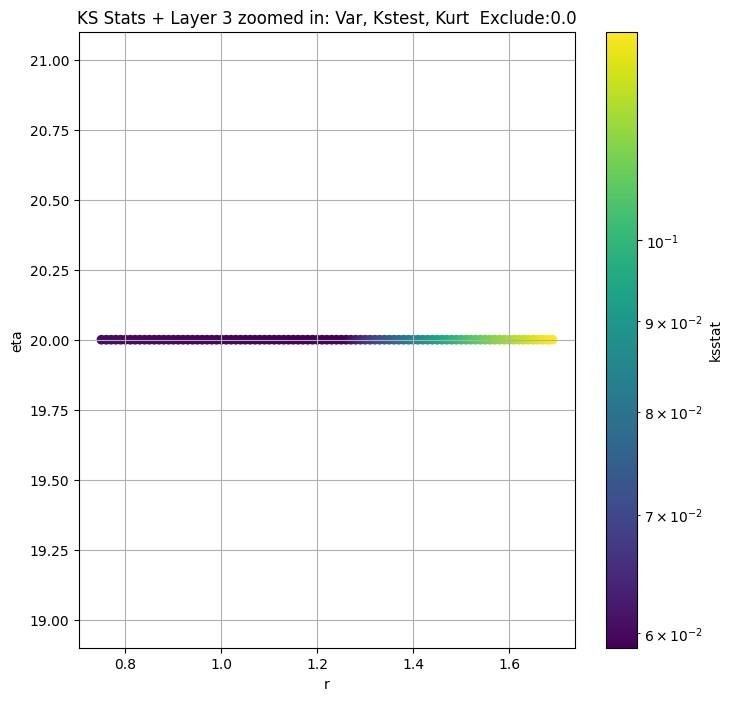

Layer 4


100%|██████████| 73/73 [00:00<00:00, 182.26it/s]


Finding Minimum after computing 73 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.02464544786664985, var: 382566.0


100%|██████████| 73/73 [00:00<00:00, 186.55it/s]


Finding Minimum after computing 73 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.024246841715116763, var: 384513.40625


100%|██████████| 73/73 [00:00<00:00, 183.79it/s]


Finding Minimum after computing 73 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.023813377589125218, var: 386605.65625


100%|██████████| 73/73 [00:00<00:00, 178.89it/s]


Finding Minimum after computing 73 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.02333848499393043, var: 388954.6875


100%|██████████| 73/73 [00:00<00:00, 184.96it/s]


Finding Minimum after computing 73 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.022741035533411502, var: 391889.4375
Number of samples: 100000, Without approximation : 177766.0


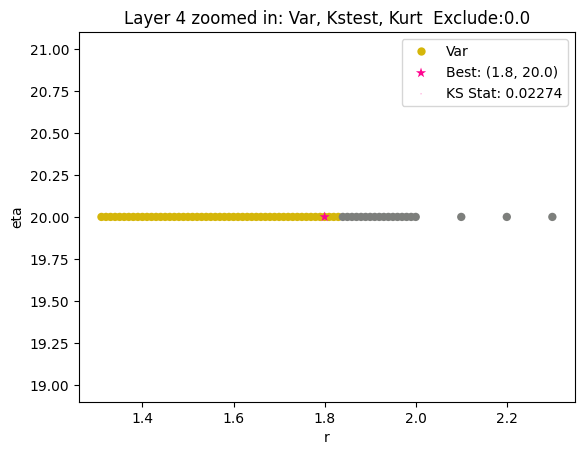

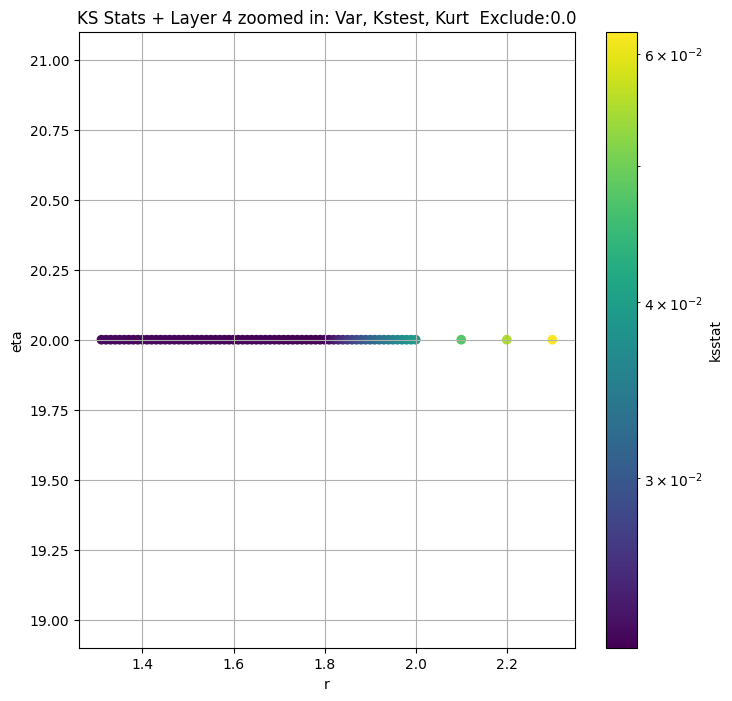

Layer 5


100%|██████████| 1377/1377 [00:07<00:00, 182.19it/s]


Finding Minimum after computing 1377 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.005621774576893009, var: 111501.1953125


100%|██████████| 1377/1377 [00:07<00:00, 186.54it/s]


Finding Minimum after computing 1377 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.0052066895969049565, var: 112340.3984375


100%|██████████| 1377/1377 [00:07<00:00, 187.00it/s]


Finding Minimum after computing 1377 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.004733482057376004, var: 113251.8671875


100%|██████████| 1377/1377 [00:07<00:00, 187.13it/s]


Finding Minimum after computing 1377 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.004213496045471159, var: 114269.53125


100%|██████████| 1377/1377 [00:07<00:00, 186.60it/s]


Finding Minimum after computing 1377 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0035944355426869024, var: 115589.140625
Number of samples: 100000, Without approximation : 820632.0


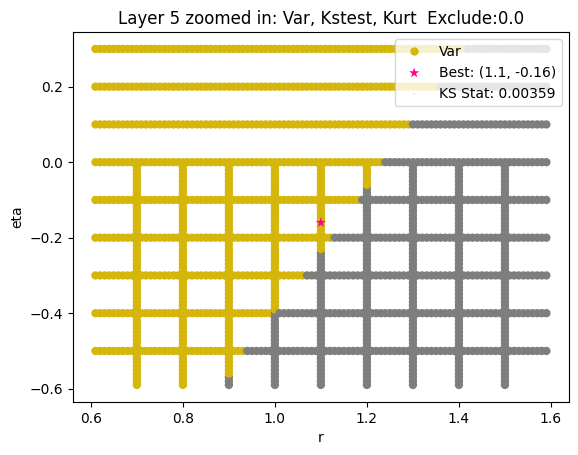

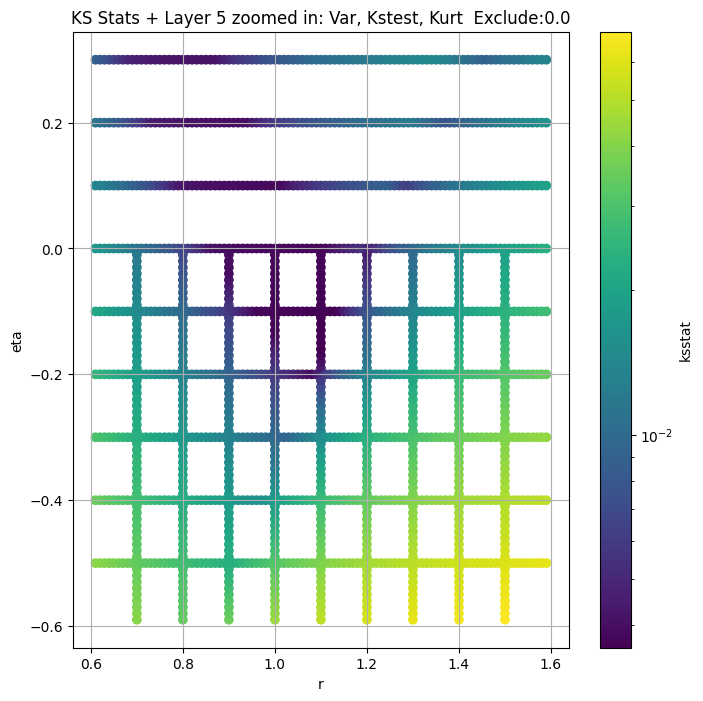

Layer 6


100%|██████████| 1701/1701 [00:09<00:00, 174.15it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.006084064357030794, var: 29355.306640625


100%|██████████| 1701/1701 [00:09<00:00, 186.84it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.005862476580818348, var: 29686.54296875


100%|██████████| 1701/1701 [00:09<00:00, 186.89it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.005640594834295727, var: 30027.884765625


100%|██████████| 1701/1701 [00:09<00:00, 186.42it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.00542781082786324, var: 30379.001953125


100%|██████████| 1701/1701 [00:09<00:00, 186.81it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.005209954202721075, var: 30741.357421875


100%|██████████| 1701/1701 [00:09<00:00, 185.96it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.0049932110865112955, var: 31115.671875


100%|██████████| 1701/1701 [00:09<00:00, 186.96it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.004780680335559697, var: 31503.26171875


100%|██████████| 1701/1701 [00:09<00:00, 186.68it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.004861322210102048, var: 31905.0234375


100%|██████████| 1701/1701 [00:09<00:00, 178.15it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.00501522381563034, var: 32322.927734375
Number of samples: 100000, Without approximation : 3670424.0


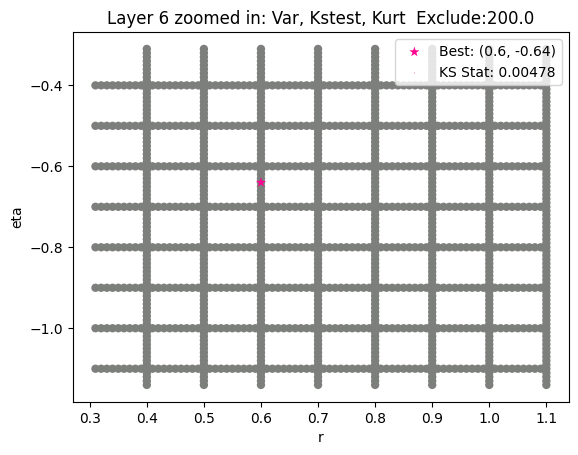

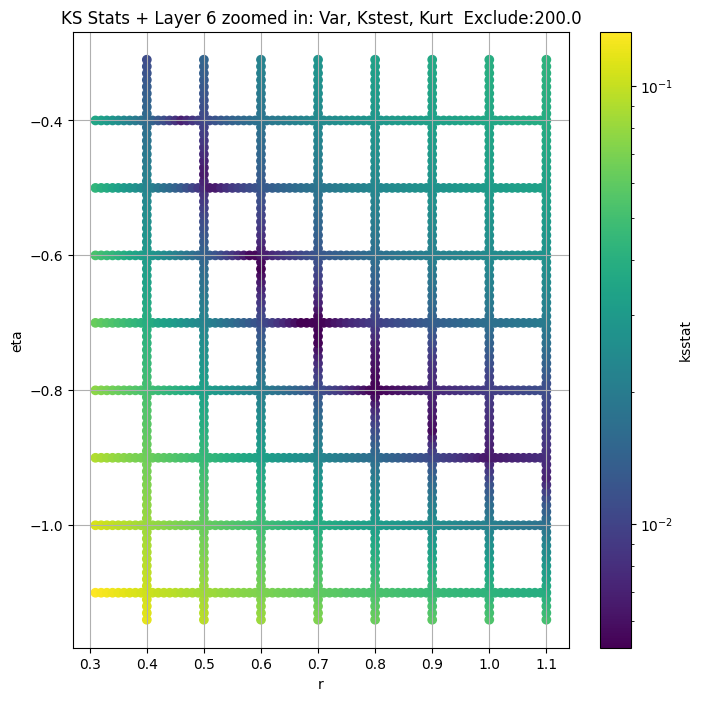

Layer 7


100%|██████████| 1692/1692 [00:09<00:00, 184.48it/s]


Finding Minimum after computing 1692 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.0048359652640977, var: 5642.82421875


100%|██████████| 1692/1692 [00:09<00:00, 186.41it/s]


Finding Minimum after computing 1692 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.004633338850067835, var: 5728.12939453125


100%|██████████| 1692/1692 [00:09<00:00, 186.52it/s]


Finding Minimum after computing 1692 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.004445521893638964, var: 5817.1962890625


100%|██████████| 1692/1692 [00:09<00:00, 184.54it/s]


Finding Minimum after computing 1692 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.004293694336374387, var: 5910.3759765625


100%|██████████| 1692/1692 [00:09<00:00, 186.08it/s]


Finding Minimum after computing 1692 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.004147624273246331, var: 6008.11083984375


100%|██████████| 1692/1692 [00:09<00:00, 187.00it/s]


Finding Minimum after computing 1692 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.0043845406538843, var: 6110.9931640625


100%|██████████| 1692/1692 [00:09<00:00, 186.59it/s]


Finding Minimum after computing 1692 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.0047964167980393685, var: 6220.14794921875


100%|██████████| 1692/1692 [00:09<00:00, 173.09it/s]


Finding Minimum after computing 1692 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.004877030523746884, var: 6336.8837890625


100%|██████████| 1692/1692 [00:09<00:00, 186.94it/s]


Finding Minimum after computing 1692 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.004978436890666071, var: 6463.23046875
Number of samples: 100000, Without approximation : 15384514.0


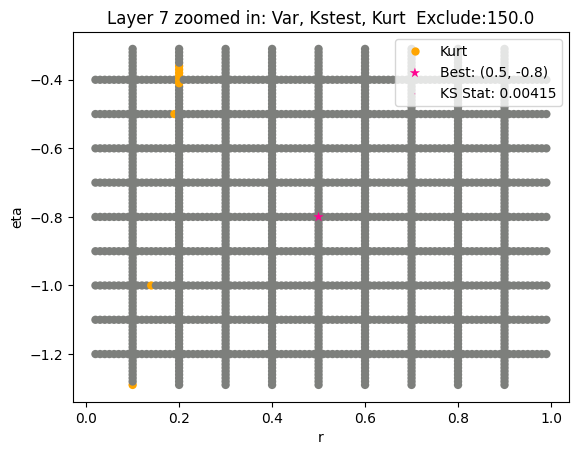

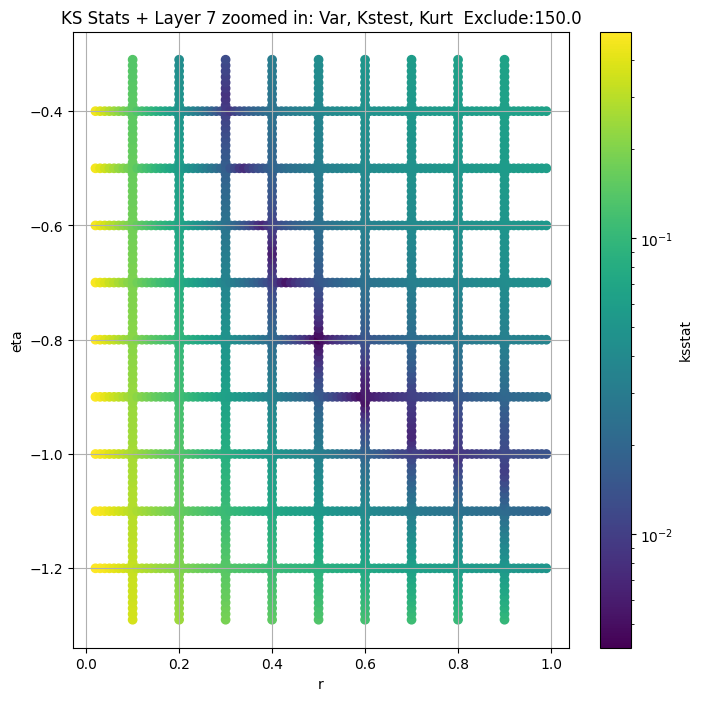

Layer 8


100%|██████████| 1512/1512 [00:08<00:00, 186.65it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 50.0 + 100 = 150, ksstat: 0.0035011886969050776, var: 634.4102172851562


100%|██████████| 1512/1512 [00:08<00:00, 186.04it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 50.0 + 75 = 125, ksstat: 0.0032276333450848606, var: 646.6893920898438


100%|██████████| 1512/1512 [00:08<00:00, 187.16it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 50.0 + 50 = 100, ksstat: 0.003260330262269462, var: 659.8395385742188


100%|██████████| 1512/1512 [00:08<00:00, 186.04it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 50.0 + 25 = 75, ksstat: 0.0034433994736518675, var: 674.0501708984375


100%|██████████| 1512/1512 [00:08<00:00, 186.49it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 50.0 + 0 = 50, ksstat: 0.003943554931642113, var: 689.6642456054688


100%|██████████| 1512/1512 [00:08<00:00, 187.26it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 50.0 + -25 = 25, ksstat: 0.003745851483119997, var: 707.4241333007812


100%|██████████| 1512/1512 [00:08<00:00, 186.28it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 50.0 + -50 = 0, ksstat: 0.00418876323659384, var: 735.1624755859375
Number of samples: 100000, Without approximation : 62976002.0


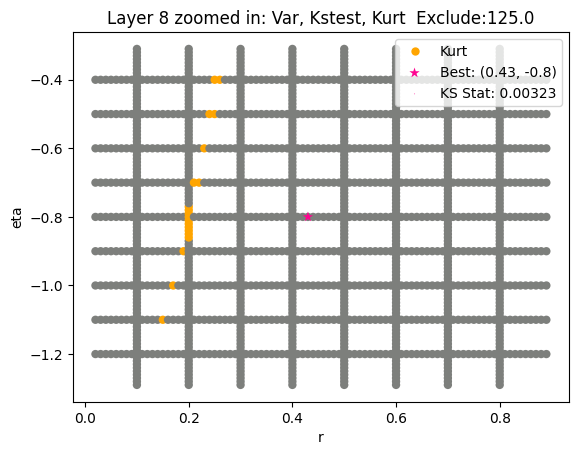

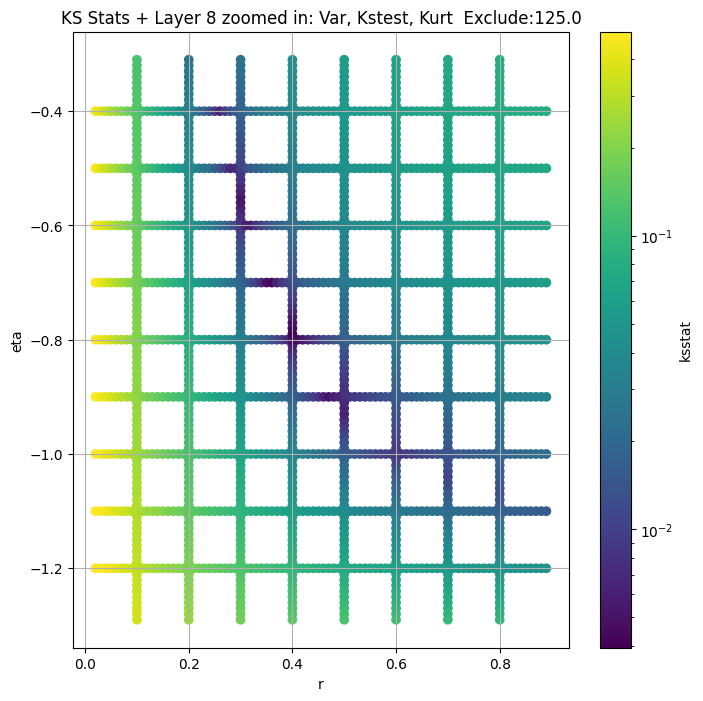

Layer 9


100%|██████████| 1410/1410 [00:08<00:00, 170.54it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 50.0 + 100 = 150, ksstat: 0.003364083527609276, var: 52.17608642578125


100%|██████████| 1410/1410 [00:07<00:00, 186.83it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 50.0 + 75 = 125, ksstat: 0.0029319920391702725, var: 53.55767822265625


100%|██████████| 1410/1410 [00:07<00:00, 185.95it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 50.0 + 50 = 100, ksstat: 0.002551078784645666, var: 55.09294128417969


100%|██████████| 1410/1410 [00:07<00:00, 186.74it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 50.0 + 25 = 75, ksstat: 0.002579908825924182, var: 56.822147369384766


100%|██████████| 1410/1410 [00:07<00:00, 186.73it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 50.0 + 0 = 50, ksstat: 0.003018647637752392, var: 58.812320709228516


100%|██████████| 1410/1410 [00:07<00:00, 186.18it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 50.0 + -25 = 25, ksstat: 0.002199366736833963, var: 61.20077133178711


100%|██████████| 1410/1410 [00:07<00:00, 187.01it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 50.0 + -50 = 0, ksstat: 0.0027242719319108266, var: 65.5811996459961
Number of samples: 100000, Without approximation : 254776200.0


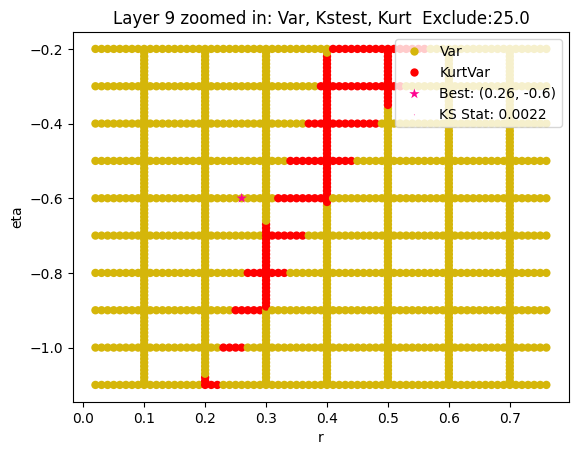

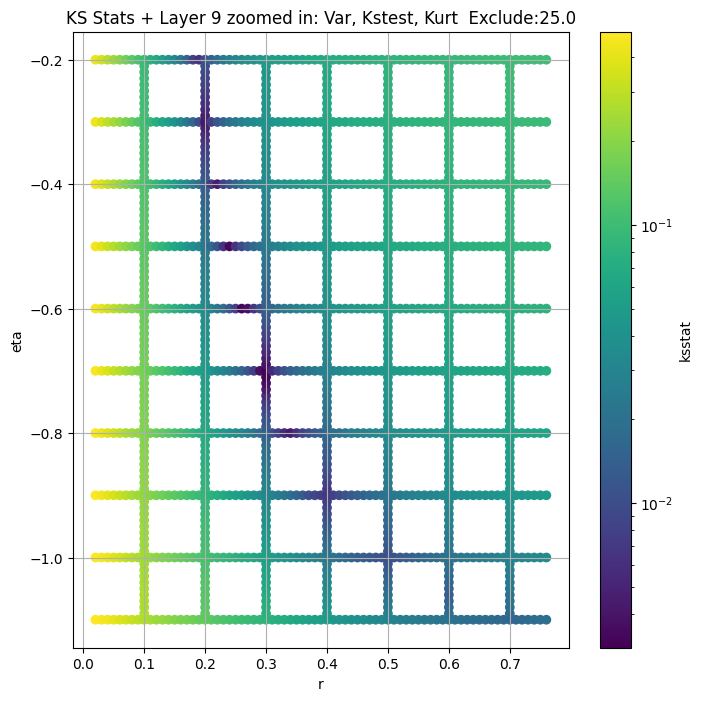

Cannot compute pval with ksstat : nan, n : 0.0


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,946814.5600,917571.90000,976698.900000,-0.538544,-0.614867,-0.456596,19544.0,0.058964,1.2,20.0,85813.709057,0.0,946814.562500,0.009706,0.058884,1.25,20.00,97690.026116,0.0,513
4,391889.4400,377544.62000,406418.840000,0.024666,-0.124355,0.191041,177766.0,0.022741,1.8,20.0,99820.241572,0.0,391889.440000,0.003220,0.022741,1.80,20.00,99820.241572,0.0,3513
5,115589.1400,110075.95000,121213.900000,1.517275,1.208930,1.873680,820632.0,0.003648,1.1,-0.1,95560.656558,0.0,115589.140625,0.001499,0.003594,1.10,-0.16,99556.170261,0.0,146052
6,35460.4960,32829.09400,38199.375000,6.683017,5.882577,7.561228,3670424.0,0.005309,0.8,-0.8,31617.404712,250.0,31503.261719,0.000709,0.004781,0.60,-0.64,12700.235886,200.0,81654
7,6775.7340,6192.90530,7381.213000,9.732124,8.434924,11.334869,15384514.0,0.004148,0.5,-0.8,1788.128226,150.0,6008.111000,0.000346,0.004148,0.50,-0.80,1788.128226,150.0,108289
8,735.1625,664.87320,812.648600,13.064596,9.912193,20.730494,62976002.0,0.004531,0.4,-0.8,76.504291,50.0,646.689392,0.000171,0.003228,0.43,-0.80,102.460766,125.0,184500
9,65.5812,57.39219,75.238235,25.357120,15.238648,48.869812,254776200.0,0.003019,0.3,-0.7,0.737396,50.0,61.200771,0.000085,0.002199,0.26,-0.60,0.151117,25.0,373206


In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

> In quadgk/vadapt (line 278)
In quadgk (line 204)
In compute_cdf_using_gengamma_with_scale (line 10)


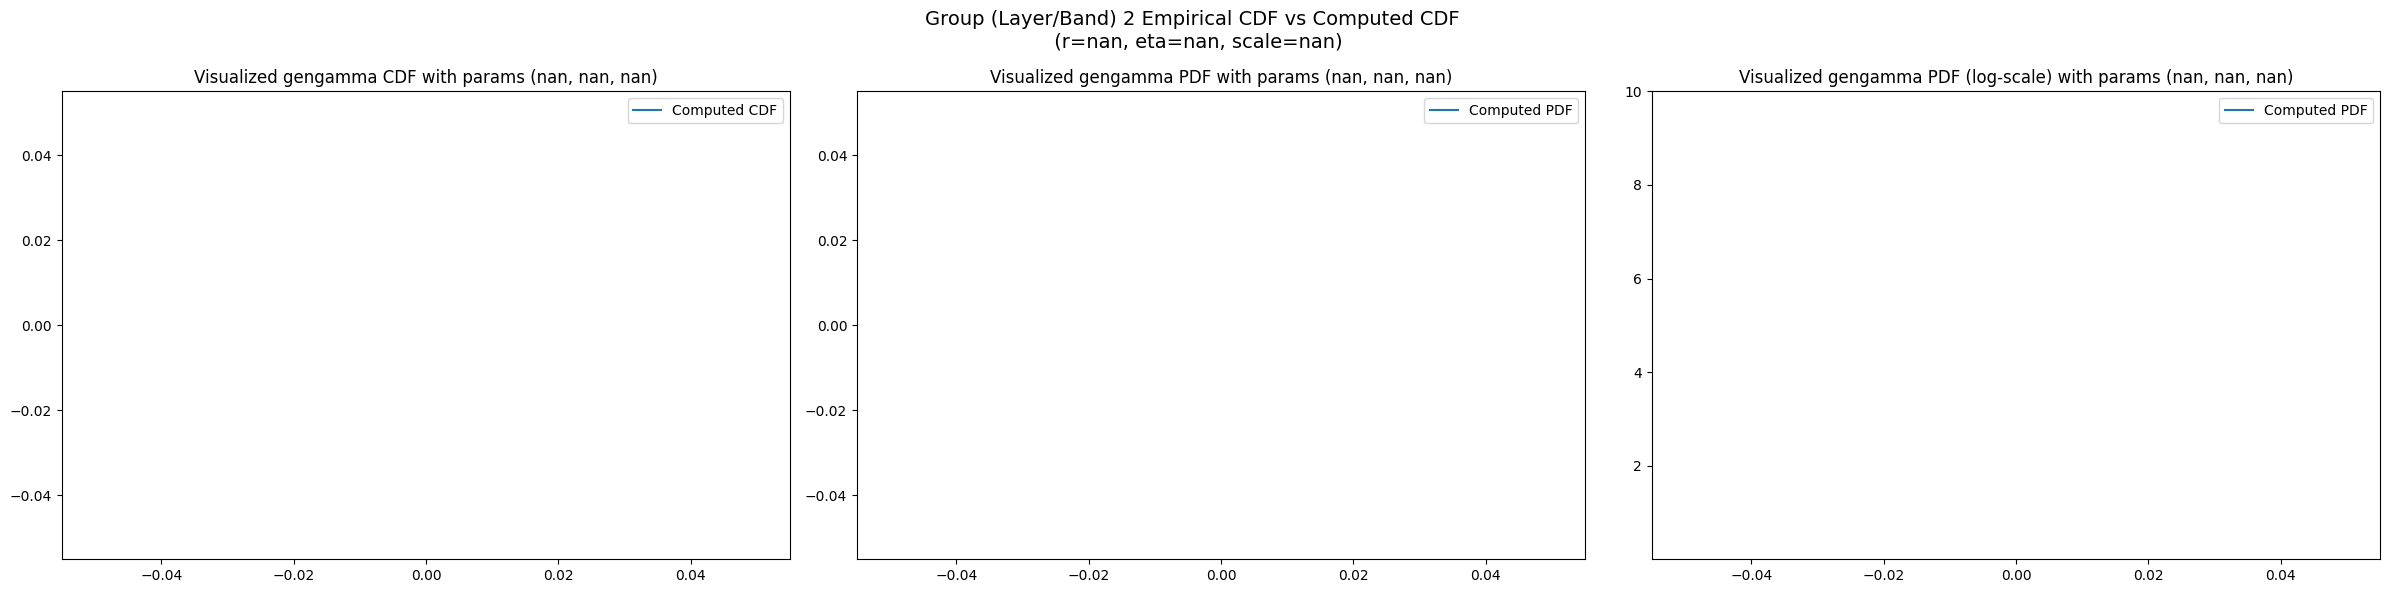

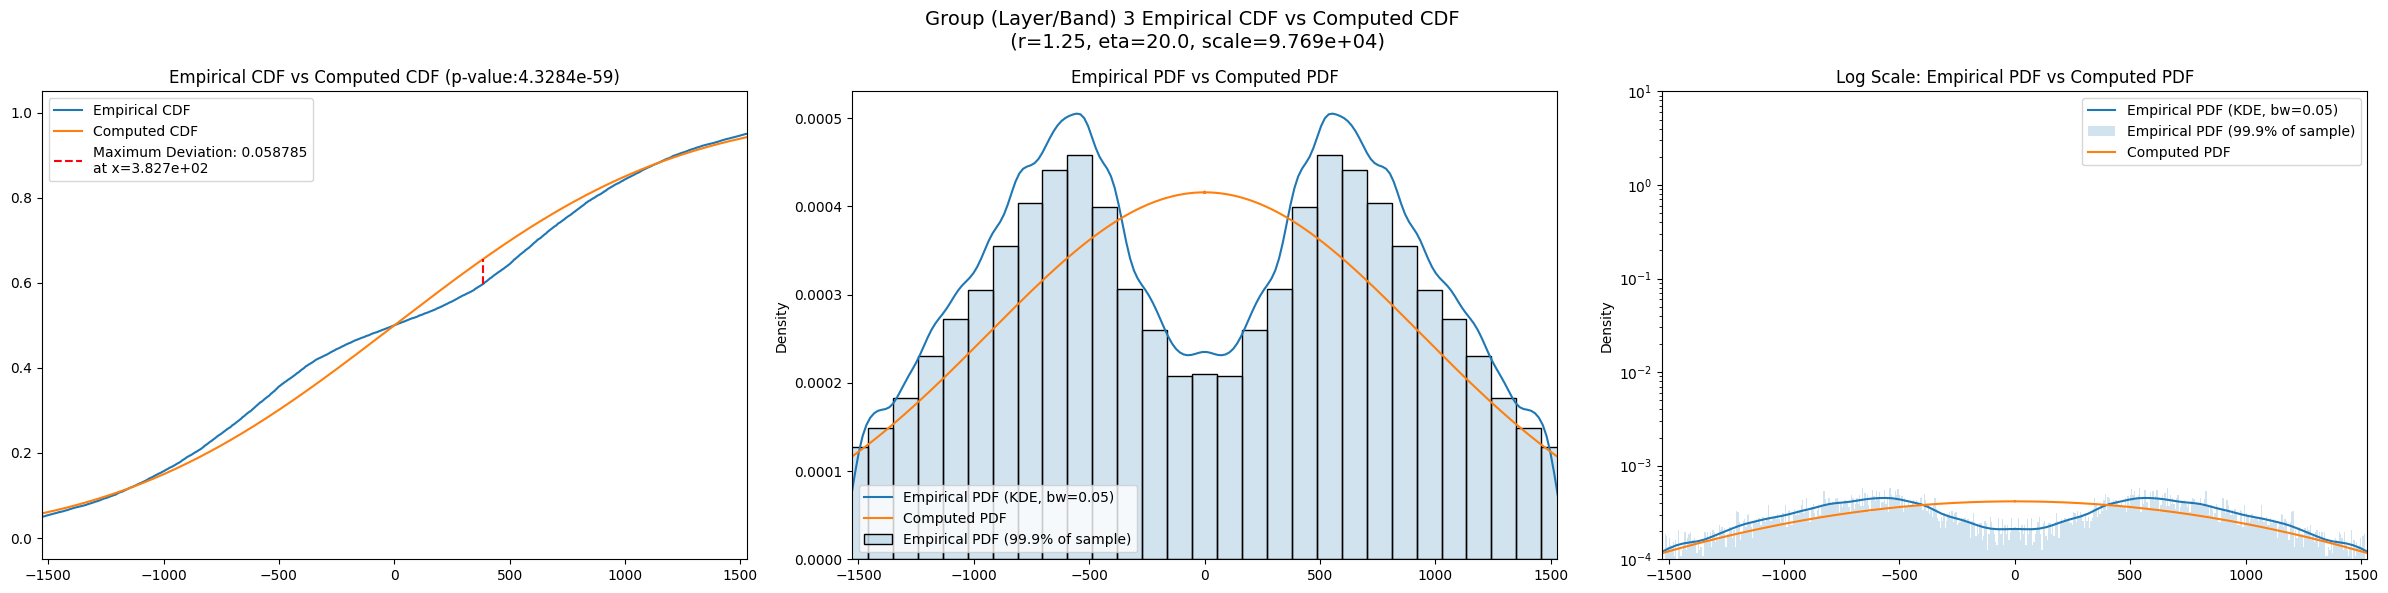

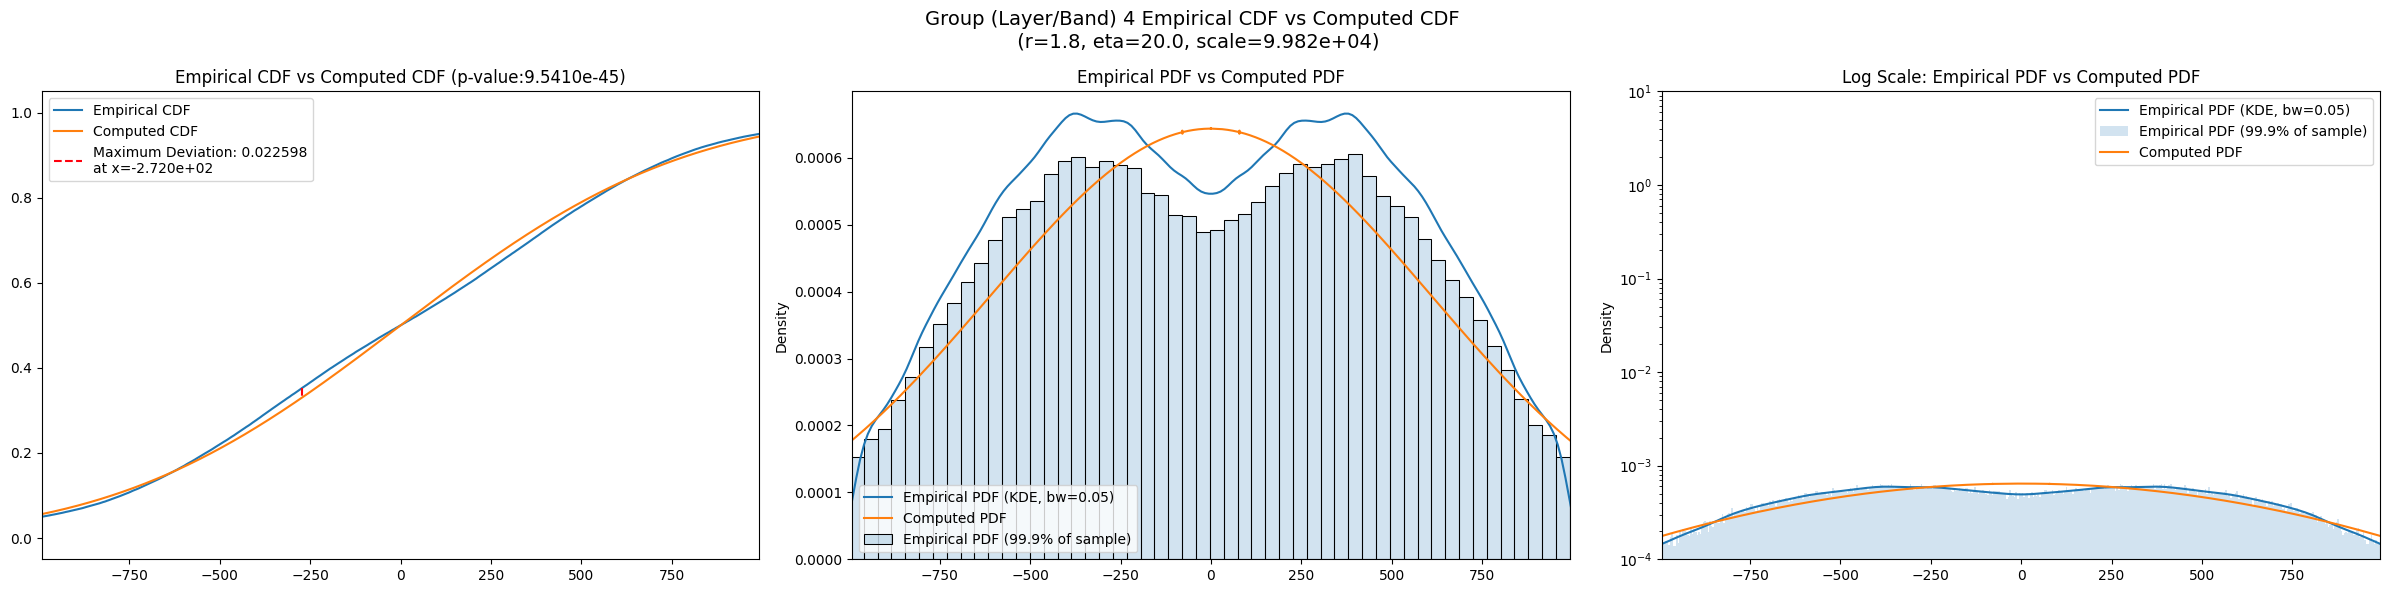

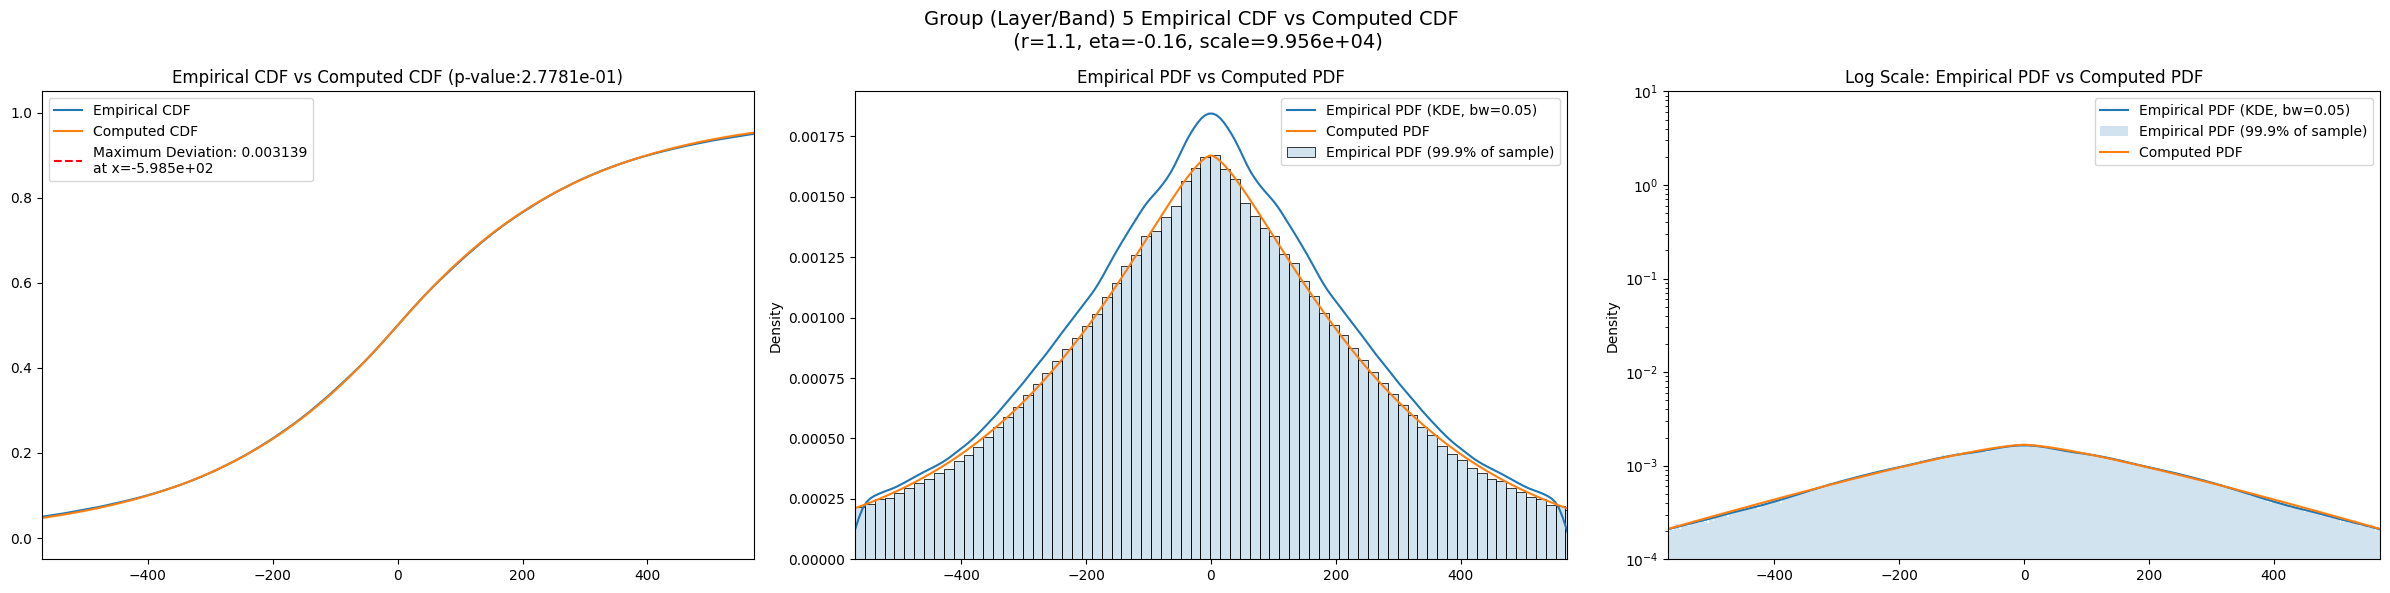

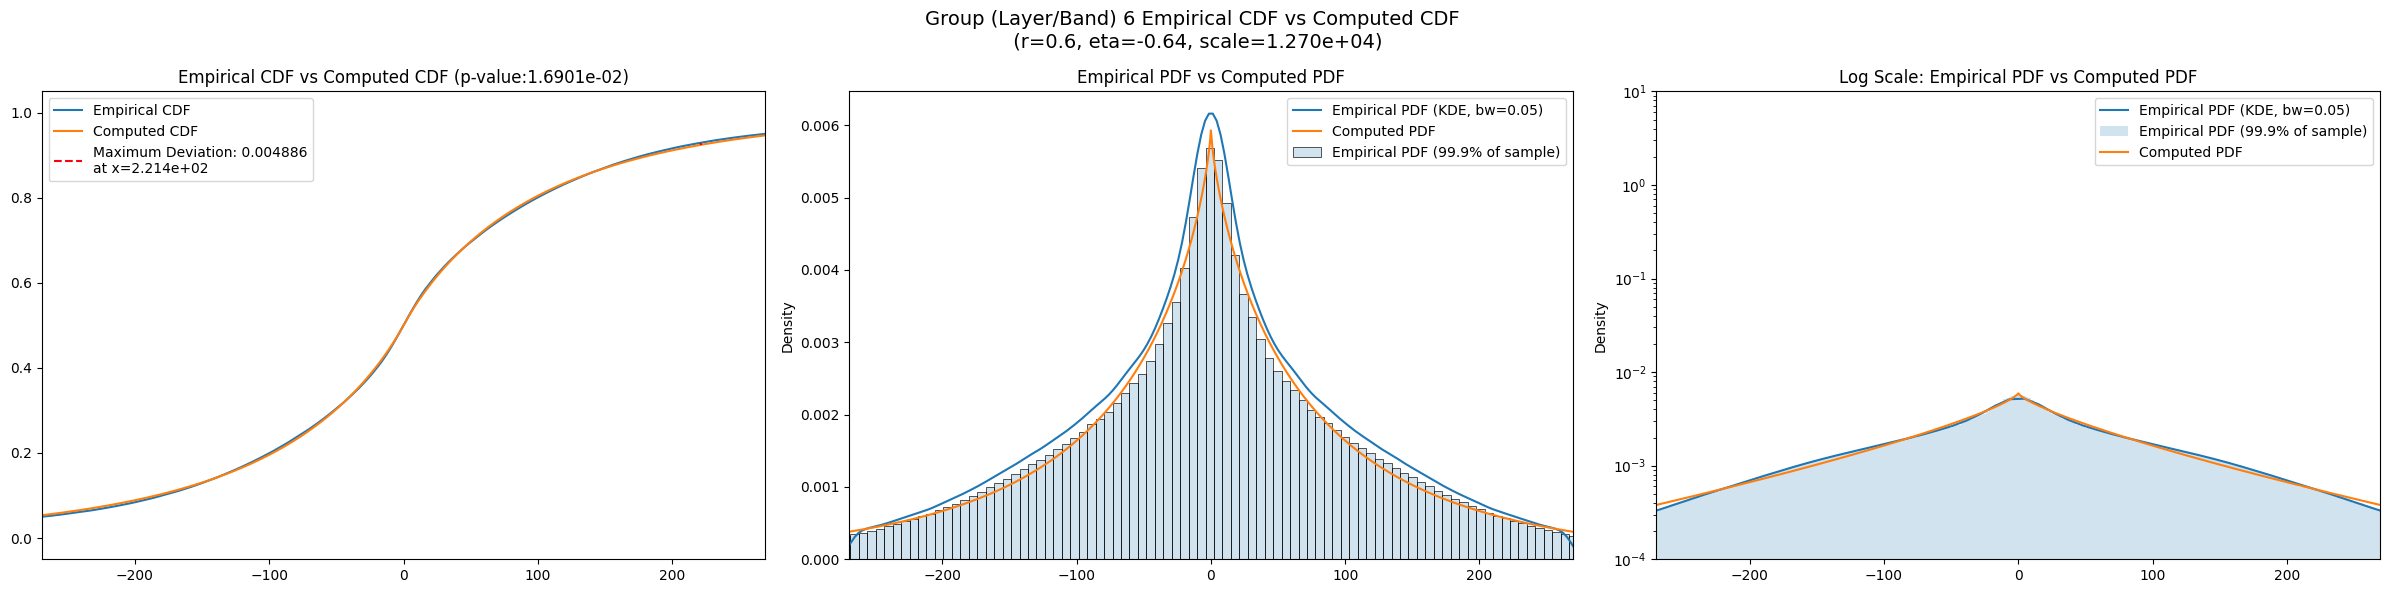

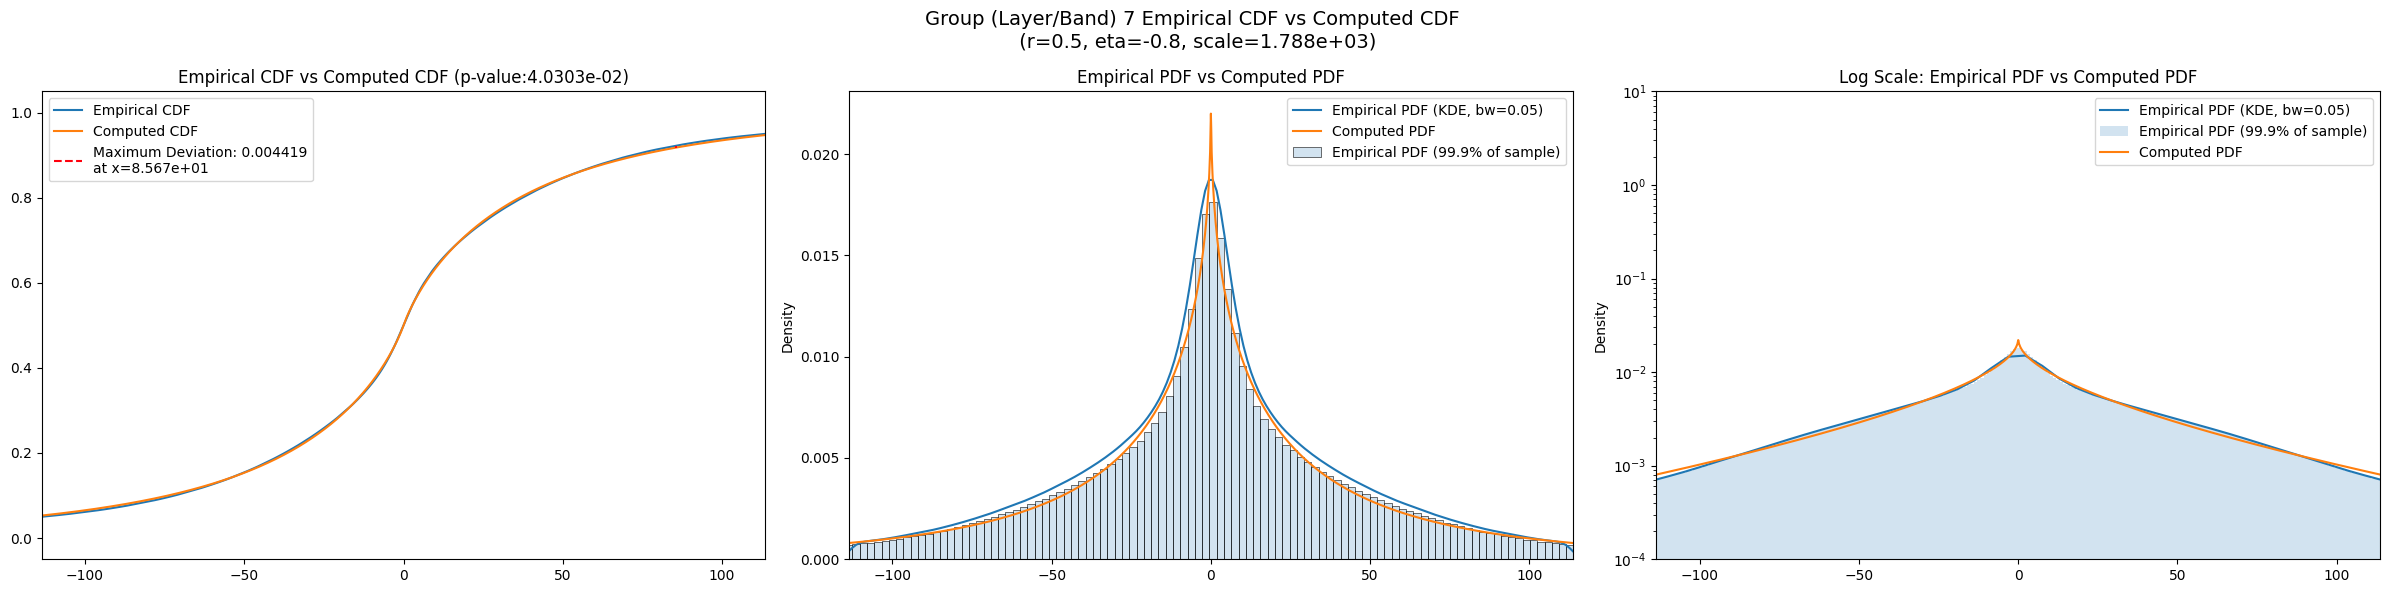

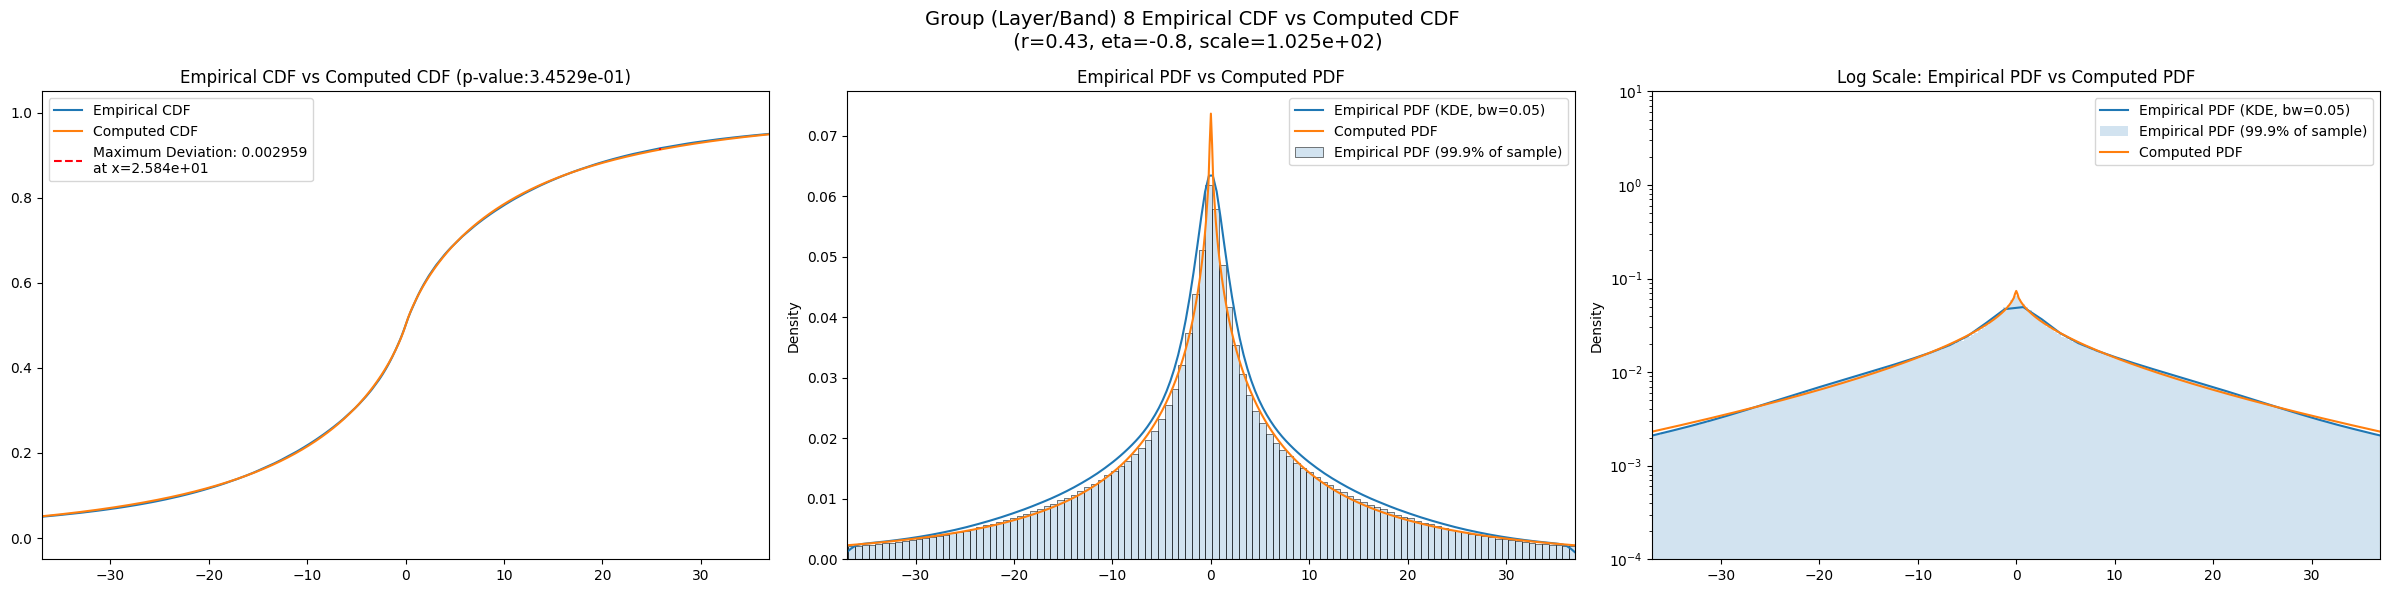

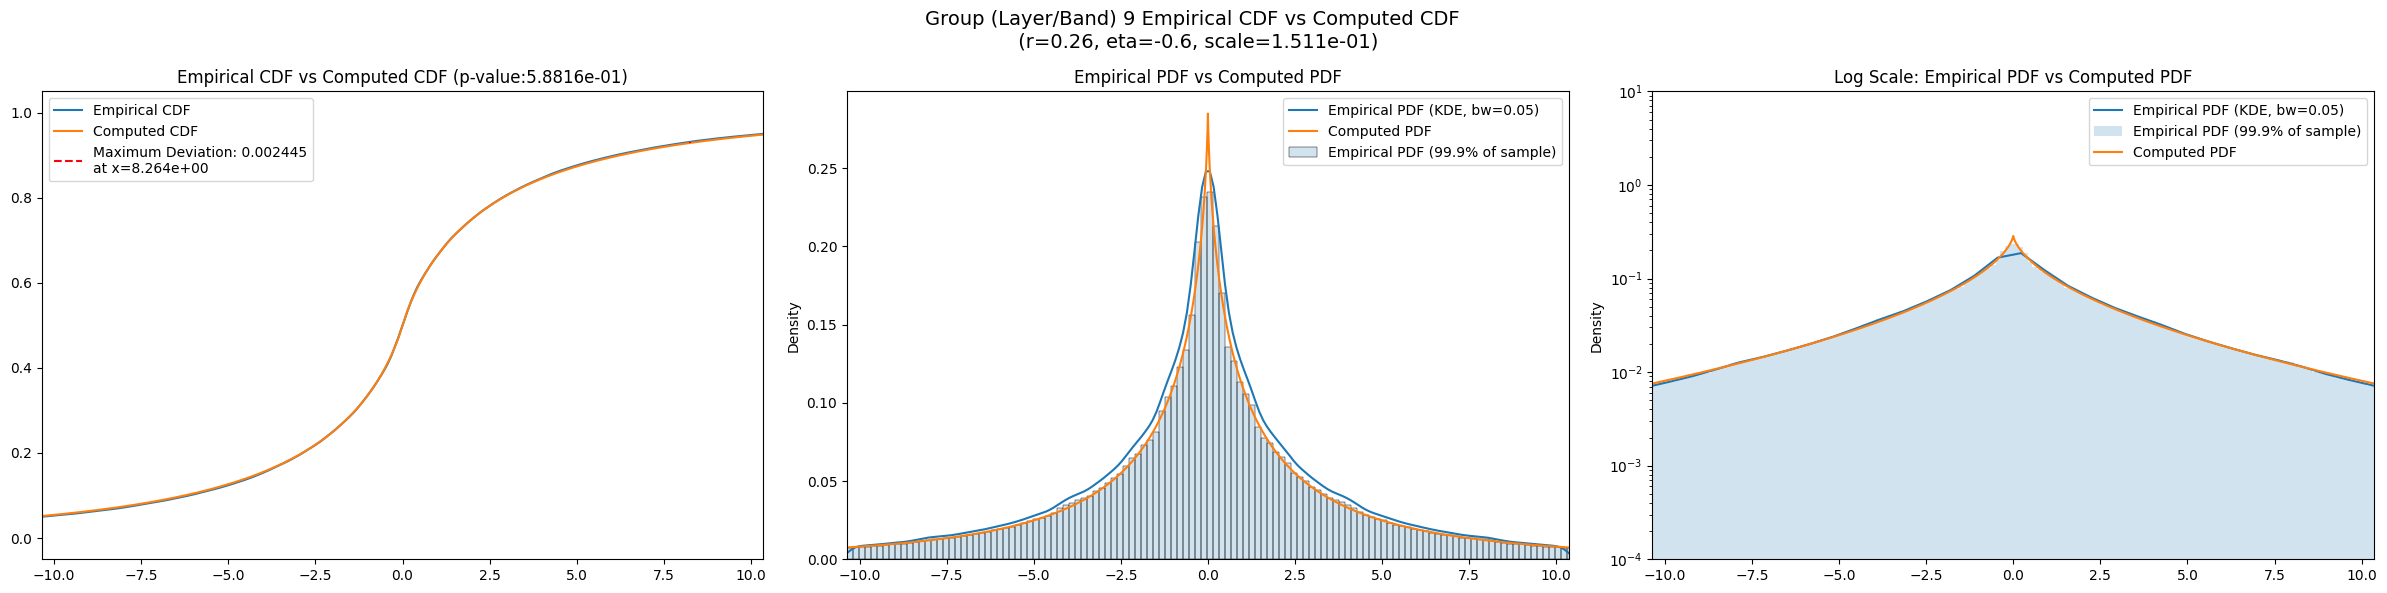

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,946814.5600,917571.90000,976698.900000,-0.538544,-0.614867,-0.456596,19544.0,0.058964,1.2,20.0,...,1119.73000,0.038269,2.635150e-25,1016.46000,0.061146,5.781950e-64,840.7080,0.057166,5.863870e-56,2.395555e-59
4,391889.4400,377544.62000,406418.840000,0.024666,-0.124355,0.191041,177766.0,0.022741,1.8,20.0,...,646.99200,0.017036,3.007630e-45,583.02400,0.041014,2.853750e-260,481.3360,0.038752,2.183140e-232,2.715134e-80
5,115589.1400,110075.95000,121213.900000,1.517275,1.208930,1.873680,820632.0,0.003648,1.1,-0.1,...,300.04400,0.021925,0.000000e+00,262.43700,0.007969,1.088480e-45,208.2260,0.015475,3.901440e-171,1.232303e-09
6,35460.4960,32829.09400,38199.375000,6.683017,5.882577,7.561228,3670424.0,0.005309,0.8,-0.8,...,120.35000,0.038814,0.000000e+00,105.12400,0.013929,0.000000e+00,86.0669,0.019461,0.000000e+00,2.729974e-73
7,6775.7340,6192.90530,7381.213000,9.732124,8.434924,11.334869,15384514.0,0.004148,0.5,-0.8,...,45.00140,0.049765,0.000000e+00,38.75480,0.023859,0.000000e+00,31.4570,0.028526,0.000000e+00,2.643001e-230
8,735.1625,664.87320,812.648600,13.064596,9.912193,20.730494,62976002.0,0.004531,0.4,-0.8,...,13.89100,0.053662,0.000000e+00,12.03330,0.027600,0.000000e+00,9.6119,0.030734,0.000000e+00,0.000000e+00
9,65.5812,57.39219,75.238235,25.357120,15.238648,48.869812,254776200.0,0.003019,0.3,-0.7,...,3.68885,0.057842,0.000000e+00,3.21604,0.031120,0.000000e+00,2.5231,0.032639,0.000000e+00,0.000000e+00


## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN
3,0.058964,0.009706,0.058884,0.038269,0.061146,0.057166
4,0.022741,0.003220,0.022741,0.017036,0.041014,0.038752
5,0.003648,0.001499,0.003594,0.021925,0.007969,0.015475
6,0.005309,0.000709,0.004781,0.038814,0.013929,0.019461
7,0.004148,0.000346,0.004148,0.049765,0.023859,0.028526
8,0.004531,0.000171,0.003228,0.053662,0.027600,0.030734
9,0.003019,0.000085,0.002199,0.057842,0.031120,0.032639


In [20]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
layer,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN
3,946814.562500,0.058884,1.25,20.00,97690.026116,0.0
4,391889.440000,0.022741,1.80,20.00,99820.241572,0.0
5,115589.140625,0.003594,1.10,-0.16,99556.170261,0.0
6,31503.261719,0.004781,0.60,-0.64,12700.235886,200.0
7,6008.111000,0.004148,0.50,-0.80,1788.128226,150.0
8,646.689392,0.003228,0.43,-0.80,102.460766,125.0
9,61.200771,0.002199,0.26,-0.60,0.151117,25.0


In [21]:
eng.quit()